In [22]:
import torch
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from tqdm import tqdm
from torch.utils.data import random_split

In [23]:
class DropNorm(nn.Module):
	def __init__(self, size_in, size_out):
		super().__init__()

		self.size_in, self.size_out = size_in, size_out

		self.weights = nn.Parameter(torch.Tensor(size_out, size_in))  # nn.Parameter is a Tensor that's a module parameter.
		self.bias = nn.Parameter(torch.Tensor(size_out))

		self.linear1 = nn.Linear(size_in, size_out)
		self.activation = nn.ReLU(inplace=True) # inplace = don't use extra memory

		self.drop_probability = 0.5  # We can take as argument but this question doesn't requires it.
		
	
	def forward(self, batch):
		# First dim = batch size
		# Second dim = sample

		mu = batch.mean(dim=1) # Mean
		sigma = batch.std(dim=1) # Standard deviation
		epsilon = .00001 # To avoid division by zero
		A = torch.sqrt((sigma ** 2) + epsilon)

		# batch: [600, 2049]
		# mu: [600]
		# We need to substract mu from each dimension of batch.

		# (batch[0] - mu[0]) is like: [2049] - [1]

		#batch[0] = batch[0] - mu[0]
		#batch[1] = batch[1] - mu[1]
		# ...
		mu = torch.unsqueeze(mu, 1)
		B = batch - mu

		A = torch.unsqueeze(A, 1)
		new_x = B / A

		mask = torch.bernoulli(batch, self.drop_probability)

		new_x = new_x * mask

		return new_x


# Defining the model

In [24]:
model = nn.Sequential(
	nn.Linear(784, 1024),
	nn.ReLU(),

	nn.Linear(1024, 512),
	nn.ReLU(),

	DropNorm(512, 512),
	nn.ReLU(),

	nn.Linear(512, 128),
	nn.ReLU(),

	DropNorm(128, 128),
	nn.ReLU(),

	nn.Linear(128, 10),
	nn.Softmax(dim=1)
)

In [25]:
BATCH_SIZE = 800
EPOCHS = 20
LR = 0.000001  # Learning rate, less = more epochs needed and more accuracy, more = less epochs needed but less accuracy
WEIGHT_DECAY = 0.001  # Should reduce overfitting

In [43]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: " + DEVICE)

model.cuda()

Using device: cuda


Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): DropNorm(
    (linear1): Linear(in_features=512, out_features=512, bias=True)
    (activation): ReLU(inplace=True)
  )
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): ReLU()
  (8): DropNorm(
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (activation): ReLU(inplace=True)
  )
  (9): ReLU()
  (10): Linear(in_features=128, out_features=10, bias=True)
  (11): Softmax(dim=1)
)

In [27]:
dataset = torchvision.datasets.FashionMNIST(root="~/22961", train=True, download=True, transform=torchvision.transforms.PILToTensor())

train_dataset, test_dataset = random_split(dataset, [45000, 15000])
train_dataset, test_dataset = train_dataset.dataset, test_dataset.dataset

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

labels = train_dataset.classes

print("Labels: ", labels)

num_batches=len(train_dataloader)

Labels:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Loss, optimizer

In [28]:
loss_func=torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [29]:
next(model.parameters()).is_cuda # returns a boolean

True

In [30]:
def iterate_batch():
	imgs, labels = next(iter(train_dataloader))
	labels = labels.cuda() # GPU

	imgs = imgs.flatten(start_dim=1)
	imgs = imgs.float().cuda() # GPU

	optimizer.zero_grad()
	y_model=model(imgs)

	loss=loss_func(y_model,labels)
	loss.backward()
	optimizer.step()

	predicted_labels = y_model.argmax(dim=1)
	acc = (predicted_labels == labels).sum()/len(labels)
	return loss.detach(), acc.detach()

In [31]:
def iterate_epoch():
	running_loss=0.
	running_acc=0.
	for _ in range(num_batches):
		batch_loss, batch_acc = iterate_batch()
		running_loss += batch_loss
		running_acc +=  batch_acc
	loss=running_loss/num_batches
	acc=running_acc/num_batches
	return loss, acc

In [32]:
def eval_model_test():
	loss=0.
	acc=0.
	for imgs, labels in test_dataloader:
		imgs = imgs.flatten(start_dim=1)
		imgs = imgs.float().cuda() # GPU
		labels = labels.cuda()
		with torch.no_grad():
			y_model=model(imgs)
			loss += loss_func(y_model,labels)
			predicted_labels = y_model.argmax(dim=1)
			acc += (predicted_labels == labels).sum()/len(labels)
	return loss/num_batches, acc/num_batches

# Train and test the model

In [33]:
loss_train=torch.zeros(EPOCHS)
acc_train=torch.zeros(EPOCHS)
loss_test=torch.zeros(EPOCHS)
acc_test=torch.zeros(EPOCHS)

model[0].reset_parameters()
for epoch_idx in tqdm(range(EPOCHS)):
	loss_train[epoch_idx], acc_train[epoch_idx] = iterate_epoch()
	loss_test[epoch_idx], acc_test[epoch_idx] = eval_model_test()

100%|██████████| 20/20 [02:36<00:00,  7.81s/it]


Text(0.5, 0, 'Epoch Number')

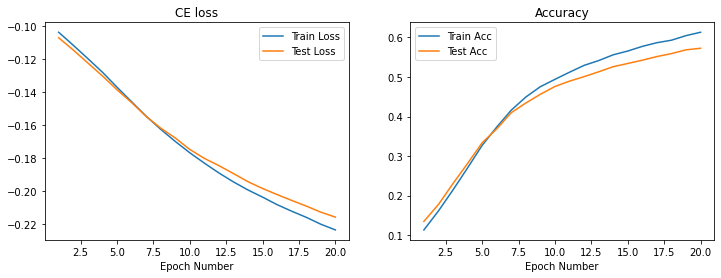

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,EPOCHS+1),loss_train,label="Train Loss")
plt.plot(range(1,EPOCHS+1),loss_test,label="Test Loss")
plt.title("CE loss")
plt.legend()
plt.xlabel("Epoch Number")
plt.subplot(1,2,2)
plt.plot(range(1,EPOCHS+1),acc_train,label="Train Acc")
plt.plot(range(1,EPOCHS+1),acc_test,label="Test Acc")
plt.title("Accuracy")
plt.legend()
plt.xlabel("Epoch Number")

In [35]:
print("Test accuracy: ", acc_test[-1])

Test accuracy:  tensor(0.5726)


# Compared to built in dropout

In [36]:
pytorch_model = nn.Sequential(
	nn.Linear(784, 1024),
	nn.ReLU(),

	nn.Linear(1024, 512),
	nn.ReLU(),

	#DropNorm(512, 512),
	nn.Dropout(p=0.5),
	nn.ReLU(),

	nn.Linear(512, 128),
	nn.ReLU(),

	DropNorm(128, 128),
	nn.ReLU(),

	nn.Linear(128, 10),
	nn.Softmax(dim=1)
)

In [37]:
def pytorch_iterate_batch():
	imgs, labels = next(iter(train_dataloader))
	imgs = imgs.flatten(start_dim=1)

	optimizer.zero_grad()
	y_model=pytorch_model(imgs.float())

	loss=loss_func(y_model,labels)
	loss.backward()
	optimizer.step()

	predicted_labels = y_model.argmax(dim=1)
	acc = (predicted_labels == labels).sum()/len(labels)
	return loss.detach(), acc.detach()

In [38]:
def pytorch_iterate_epoch():
	running_loss=0.
	running_acc=0.
	for _ in range(num_batches):
		batch_loss, batch_acc = pytorch_iterate_batch()
		running_loss += batch_loss
		running_acc +=  batch_acc
	loss=running_loss/num_batches
	acc=running_acc/num_batches
	return loss, acc

In [39]:
def pytorch_eval_model_test():
  loss=0.
  acc=0.
  for imgs, labels in test_dataloader:
    imgs = imgs.flatten(start_dim=1)
    with torch.no_grad():
      y_model=pytorch_model(imgs.float())
      loss += loss_func(y_model,labels)
      predicted_labels = y_model.argmax(dim=1)
      acc += (predicted_labels == labels).sum()/len(labels)
  return loss/num_batches, acc/num_batches

In [40]:
pytorch_loss_train=torch.zeros(EPOCHS)
pytorch_acc_train=torch.zeros(EPOCHS)
pytorch_loss_test=torch.zeros(EPOCHS)
pytorch_acc_test=torch.zeros(EPOCHS)

pytorch_model[0].reset_parameters()
for epoch_idx in tqdm(range(EPOCHS)):
	pytorch_loss_train[epoch_idx], pytorch_acc_train[epoch_idx] = pytorch_iterate_epoch()
	pytorch_loss_test[epoch_idx], pytorch_acc_test[epoch_idx] = pytorch_eval_model_test()

100%|██████████| 20/20 [05:39<00:00, 17.00s/it]


Text(0.5, 0, 'Epoch Number')

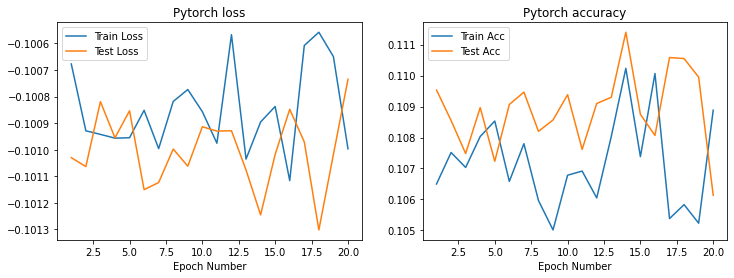

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,EPOCHS+1),pytorch_loss_train,label="Train Loss")
plt.plot(range(1,EPOCHS+1),pytorch_loss_test,label="Test Loss")
plt.title("Pytorch loss")
plt.legend()
plt.xlabel("Epoch Number")
plt.subplot(1,2,2)
plt.plot(range(1,EPOCHS+1),pytorch_acc_train,label="Train Acc")
plt.plot(range(1,EPOCHS+1),pytorch_acc_test,label="Test Acc")
plt.title("Pytorch accuracy")
plt.legend()
plt.xlabel("Epoch Number")

In [42]:
print("Test accuracy: ", pytorch_acc_test[-1])

Test accuracy:  tensor(0.1061)
